### This is an example of where Scipy default optimizer (L-BFGS-B) does not correctly estimate the inefficiency variance. Even with $\gamma$ set to 0 and small measurement error, it estimates $\eta = 0$.

#### January 22, 2021 (after SFMA meeting)
Install the latest commit of `anml` from GitHub and the `logerf` branch from `SFMA`

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sfma.api import SFMAModel

## Make Simulations

In [2]:
np.random.seed(10)

In [3]:
n = 100

In [4]:
intercept = 1.5
slope = 5

x_domain = [0, 10]

ineff = 0.4

sample_size_1 = [1000, 0.7]
sample_size_2 = [1000, 0.3]

In [5]:
def frontier(x):
    return np.log(intercept + slope * x)

In [6]:
def simulate():
    x = np.random.uniform(low=x_domain[0], high=x_domain[1], size=n)
    sample_sizes_1 = np.random.negative_binomial(
        n=sample_size_1[0], p=sample_size_1[1], size=int(n / 2)
    )
    sample_sizes_2 = np.random.negative_binomial(
        n=sample_size_2[0], p=sample_size_2[1], size=int(n / 2)
    )
    sample_sizes = np.append(sample_sizes_1, sample_sizes_2)
    
    the_frontier = frontier(x)
    inefficiency = np.random.exponential(ineff, size=n)
    means = the_frontier - inefficiency
    samples = [np.random.normal(m, scale=4, size=s) for m, s in zip(means, sample_sizes)]
    est_means = np.array([np.mean(s) for s in samples])
    est_sterr = np.array([np.sqrt(np.sum(sum((s - np.mean(s))**2)) / ((len(s) - 1)))/np.sqrt(len(s)) for s in samples])
    df = pd.DataFrame({
        'output': est_means,
        'se': est_sterr,
        'input': x,
        'ones': np.ones(len(x)),
        'frontier': the_frontier,
        'truth': means,
        'sample_size': sample_sizes
    })
    return df

In [7]:
sim = simulate()

In [8]:
the_frontier = sim['frontier']
linspace = np.linspace(x_domain[0], x_domain[1])
front = frontier(linspace)

<ErrorbarContainer object of 3 artists>

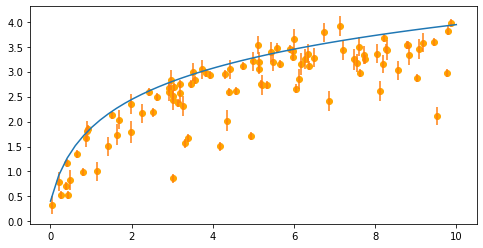

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(linspace, front, linestyle='solid')
ax.scatter(sim.input, sim.output, color='orange')
ax.errorbar(sim.input, sim.output, yerr=sim.se, linestyle='None')

In [64]:
model = SFMAModel(
    df=sim,
    col_output='output',
    col_se='se',
    col_input='input',
    include_gamma=True
)
concave = SFMAModel(
    df=sim,
    col_output='output',
    col_se='se',
    col_input='input',
    r_linear=True,
    concave=True,
    include_gamma=True,
)

In [65]:
model.fit(options={'solver_options': {}})
# concave.fit(options={'solver_options': {}})

In [66]:
sim['base_predictions'] = model.predict()
# sim['concave_predictions'] = concave.predict()
sim.sort_values('input', inplace=True)

#### The last entry is $\eta$ and you can see that it's 0 for the `model` object but non-zero correct) for the `concave` object.

In [67]:
model.x_init

array([7.87402240e-01, 3.20253479e+00, 2.51494666e+00, 4.43904996e+00,
       3.72892116e+00, 4.25677584e+00, 1.00000000e-05, 1.00000000e-05])

In [68]:
model.solver.x_opt

array([0.68275163, 2.61101742, 2.63733691, 4.16201691, 3.4151445 ,
       4.02006267, 0.        , 0.35306304])

In [69]:
concave.solver.x_opt

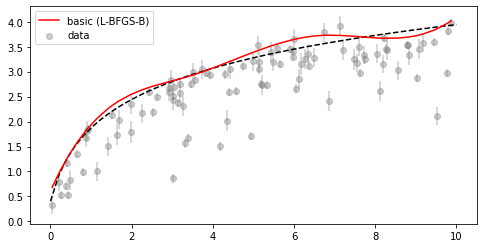

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(linspace, front, linestyle='dashed', color='black')
axes.scatter(sim.input, sim.output, color='grey', alpha=0.4, label="data")
# axes.scatter(sim.input, sim.output + concave.inefficiencies, color='#008080', alpha=0.4, label="data + inefficiency")
axes.errorbar(sim.input, sim.output, yerr=sim.se, linestyle='None', color='grey', alpha=0.4)
axes.plot(sim.input, sim.base_predictions, color='red', label='basic (L-BFGS-B)')
# axes.plot(sim.input, sim.concave_predictions, color='green', label='concave (trust-constr)')
axes.legend()
plt.savefig("results.png", bbox_inches="tight")

In [71]:
model.solver.result

      fun: -0.552024597219937
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.66759640e-06,  8.24010073e-06,  3.35204410e-06, -3.31875929e-06,
        2.86734287e-07,  3.46384030e-06,  3.23237658e+00, -7.03302016e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 40
      nit: 24
     njev: 40
   status: 0
  success: True
        x: array([0.68275163, 2.61101742, 2.63733691, 4.16201691, 3.4151445 ,
       4.02006267, 0.        , 0.35306304])

In [16]:
p = np.random.uniform(size=8)

In [17]:
p

array([0.74955214, 0.52457375, 0.58083661, 0.86982619, 0.06325029,
       0.27778705, 0.99111812, 0.68325028])

In [18]:
model.marginal_model.gradient(x=p, data=model.data)

array([-0.07049641, -0.26535982, -0.61920793, -0.69276497, -0.45934156,
       -0.24966072, -2.6798892 ,  0.54332677])

In [20]:
model.marginal_model.gradient_ad(x=p, data=model.data)

array([-0.07049641, -0.26535982, -0.61920793, -0.69276497, -0.45934156,
       -0.24966072, -2.6798892 ,  0.54332677])

In [26]:
model.data.obs.shape[0]

[autoreload of sfma.api failed: Traceback (most recent call last):
  File "/opt/miniconda3/envs/sfma/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/miniconda3/envs/sfma/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/miniconda3/envs/sfma/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/miniconda3/envs/sfma/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/marlena

100